In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as ex
import re
from xgboost import XGBClassifier , XGBRegressor
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold ,train_test_split
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import make_scorer
import plotly.express as px
from functools import partial
from imblearn.over_sampling import RandomOverSampler
import plotly.graph_objects as go
import optuna
def kappa_score(y_true , y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')


    
seasons_mapping = {
    'Winter': 1,
    'Spring': 2,
    'Summer': 3,
    'Fall': 4  # or 'Autumn': 4 if you prefer
}



# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import cross_val_score
import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

pd.set_option("display.max_rows" , 100)
pd.set_option("display.max_columns" , 100)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pciat_cols = ['PCIAT-PCIAT_03',
 'PCIAT-PCIAT_14',
 'PCIAT-PCIAT_11',
 'PCIAT-PCIAT_19',
 'PCIAT-PCIAT_15',
 'PCIAT-PCIAT_08',
 'PCIAT-PCIAT_06',
 'PCIAT-PCIAT_17',
 'PCIAT-PCIAT_07',
 'PCIAT-PCIAT_10',
 'PCIAT-Season',
 'PCIAT-PCIAT_05',
 'PCIAT-PCIAT_02',
 'PCIAT-PCIAT_12',
 'PCIAT-PCIAT_09',
 'PCIAT-PCIAT_18',
 'PCIAT-PCIAT_16',
 'PCIAT-PCIAT_04',
 'sii',
 'PCIAT-PCIAT_Total',
 'PCIAT-PCIAT_13',
 'PCIAT-PCIAT_01',
 'PCIAT-PCIAT_20']


selected = ['Physical-Height',
 'Basic_Demos-Age',
 'PreInt_EduHx-computerinternet_hoursday',
 'Physical-Weight',
 'Physical-Waist_Circumference',
 'FGC-FGC_CU',
 'BIA-BIA_BMI',
 'SDS-SDS_Total_T',
 'PAQ_A-Season',
 'FGC-FGC_PU',
 'BIA-BIA_Frame_num',
 'FGC-FGC_GSD',
 'Physical-Systolic_BP',
 'FGC-FGC_GSND',
 'FGC-FGC_TL',
 'PAQ_C-Season',
 'BIA-BIA_FFMI',
 'FGC-FGC_SRR_Zone',
 'FGC-FGC_SRL_Zone']

In [3]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
train = train.drop('id', axis=1)
id_test = test.pop("id")
train1 = train.loc[~train["sii"].isna()]
train2 = train.loc[train["sii"].isna()]

Children: Ages 6 to 12 years.
Adolescents: Ages 13 to 18 years.

In [4]:
ex.scatter( train1 ,
           x = "PCIAT-PCIAT_Total" 
           , y="sii" ,marginal_x="box" , marginal_y="histogram")

In [5]:
ex.scatter( train1 ,
           x = "PCIAT-PCIAT_Total" 
           , y="Physical-Height" ,marginal_x="box" , marginal_y="box")

In [6]:
y = train1["PCIAT-PCIAT_Total"]
X = train1[selected].replace(seasons_mapping)

test_m = test[selected].replace(seasons_mapping)
X

/tmp/ipykernel_23/3396088928.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_23/3396088928.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Physical-Height,Basic_Demos-Age,PreInt_EduHx-computerinternet_hoursday,Physical-Weight,Physical-Waist_Circumference,FGC-FGC_CU,BIA-BIA_BMI,SDS-SDS_Total_T,PAQ_A-Season,FGC-FGC_PU,BIA-BIA_Frame_num,FGC-FGC_GSD,Physical-Systolic_BP,FGC-FGC_GSND,FGC-FGC_TL,PAQ_C-Season,BIA-BIA_FFMI,FGC-FGC_SRR_Zone,FGC-FGC_SRL_Zone
0,46.0,5,3.0,50.8,NaN,0.0,16.8792,NaN,NaN,0.0,1.0,NaN,NaN,NaN,6.0,NaN,13.8177,0.0,0.0
1,48.0,9,0.0,46.0,22.0,3.0,14.0371,64.0,NaN,5.0,1.0,NaN,122.0,NaN,3.0,4.0,12.8254,1.0,1.0
2,56.5,10,2.0,75.6,NaN,20.0,NaN,54.0,NaN,7.0,NaN,14.7,117.0,10.2,5.0,3.0,NaN,1.0,1.0
3,56.0,9,0.0,81.6,NaN,18.0,18.2943,45.0,NaN,5.0,2.0,NaN,117.0,NaN,7.0,1.0,14.0740,0.0,0.0
5,59.5,13,0.0,112.2,NaN,12.0,30.1865,56.0,NaN,6.0,2.0,17.9,102.0,16.5,8.0,2.0,16.6877,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,52.5,8,2.0,67.2,25.0,0.0,17.1417,58.0,NaN,0.0,1.0,NaN,112.0,NaN,12.0,4.0,13.4004,1.0,1.0
3954,48.5,7,0.0,46.6,23.0,0.0,13.6457,67.0,NaN,0.0,1.0,NaN,105.0,NaN,4.5,NaN,13.2315,0.0,0.0
3955,59.5,13,1.0,82.4,NaN,16.0,16.3642,50.0,NaN,10.0,1.0,19.9,104.0,18.0,12.0,1.0,14.0629,1.0,1.0
3957,60.0,11,0.0,109.8,NaN,15.0,21.4438,77.0,NaN,0.0,2.0,15.8,116.0,18.5,14.0,1.0,14.8043,1.0,1.0


In [7]:
y = train1["PCIAT-PCIAT_Total"]
X = train1.replace(seasons_mapping).drop(pciat_cols , axis=1)

test_m = test.replace(seasons_mapping)
X

/tmp/ipykernel_23/780069209.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_23/780069209.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,Fitness_Endurance-Season,Fitness_Endurance-Max_Stage,Fitness_Endurance-Time_Mins,Fitness_Endurance-Time_Sec,FGC-Season,FGC-FGC_CU,FGC-FGC_CU_Zone,FGC-FGC_GSND,FGC-FGC_GSND_Zone,FGC-FGC_GSD,FGC-FGC_GSD_Zone,FGC-FGC_PU,FGC-FGC_PU_Zone,FGC-FGC_SRL,FGC-FGC_SRL_Zone,FGC-FGC_SRR,FGC-FGC_SRR_Zone,FGC-FGC_TL,FGC-FGC_TL_Zone,BIA-Season,BIA-BIA_Activity_Level_num,BIA-BIA_BMC,BIA-BIA_BMI,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_FFMI,BIA-BIA_FMI,BIA-BIA_Fat,BIA-BIA_Frame_num,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday
0,4,5,0,1.0,51.0,4.0,16.877316,46.0,50.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0.0,6.0,0.0,6.0,1.0,4.0,2.0,2.66855,16.8792,932.498,1492.00,8.25598,41.5862,13.8177,3.061430,9.21377,1.0,24.4349,8.89536,38.9177,19.5413,32.6909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0
1,3,9,0,NaN,NaN,4.0,14.035590,48.0,46.0,22.0,75.0,70.0,122.0,NaN,NaN,NaN,NaN,4.0,3.0,0.0,NaN,NaN,NaN,NaN,5.0,0.0,11.0,1.0,11.0,1.0,3.0,0.0,1.0,2.0,2.57949,14.0371,936.656,1498.65,6.01993,42.0291,12.8254,1.211720,3.97085,1.0,21.0352,14.97400,39.4497,15.4107,27.0552,NaN,NaN,4.0,2.340,4.0,46.0,64.0,3.0,0.0
2,3,10,1,4.0,71.0,4.0,16.648696,56.5,75.6,NaN,65.0,94.0,117.0,4.0,5.0,7.0,33.0,4.0,20.0,1.0,10.2,1.0,14.7,2.0,7.0,1.0,10.0,1.0,10.0,1.0,5.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,2.170,4.0,38.0,54.0,3.0,2.0
3,1,9,0,4.0,71.0,3.0,18.292347,56.0,81.6,NaN,60.0,97.0,117.0,3.0,6.0,9.0,37.0,3.0,18.0,1.0,NaN,NaN,NaN,NaN,5.0,0.0,7.0,0.0,7.0,0.0,7.0,1.0,3.0,3.0,3.84191,18.2943,1131.430,1923.44,15.59250,62.7757,14.0740,4.220330,18.82430,2.0,30.4041,16.77900,58.9338,26.4798,45.9966,NaN,NaN,1.0,2.451,3.0,31.0,45.0,1.0,0.0
5,2,13,1,1.0,50.0,3.0,22.279952,59.5,112.2,NaN,60.0,73.0,102.0,NaN,NaN,NaN,NaN,3.0,12.0,0.0,16.5,2.0,17.9,2.0,6.0,0.0,10.0,1.0,11.0,1.0,8.0,0.0,3.0,2.0,4.33036,30.1865,1330.970,1996.45,30.21240,84.0285,16.6877,13.498800,67.97150,2.0,32.9141,20.90200,79.6982,35.3804,63.1265,NaN,NaN,2.0,4.110,3.0,40.0,56.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,4,8,0,NaN,NaN,4.0,17.139810,52.5,67.2,25.0,60.0,65.0,112.0,NaN,NaN,NaN,NaN,4.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,8.0,1.0,10.0,1.0,12.0,1.0,4.0,3.0,3.20303,17.1417,1035.270,1759.96,11.00630,52.5331,13.4004,3.741300,14.66690,1.0,25.7118,15.81500,49.3301,20.2645,36.7181,NaN,NaN,4.0,3.440,4.0,41.0,58.0,4.0,2.0
3954,3,7,1,NaN,NaN,3.0,13.927006,48.5,46.6,23.0,65.0,75.0,105.0,NaN,NaN,NaN,NaN,3.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,9.0,0.0,8.5,0.0,4.5,0.0,4.0,1.0,2.36680,13.6457,966.287,1256.17,9.98802,45.1853,13.2315,0.414263,1.41470,1.0,20.0572,15.14000,42.8185,18.0937,30.0453,NaN,NaN,NaN,NaN,3.0,48.0,67.0,3.0,0.0
3955,4,13,0,2.0,60.0,4.0,16.362460,59.5,82.4,NaN,71.0,70.0,104.0,NaN,NaN,NaN,NaN,4.0,16.0,0.0,18.0,1.0,19.9,2.0,10.0,1.0,8.0,1.0,9.0,1.0,12.0,1.0,4.0,3.0,4.52277,16.3642,1206.880,2051.70,19.46110,70.8117,14.0629,2.301380,11.58830,1.0,33.3709,17.97970,66.2889,29.7790,52.8320,NaN,NaN,1.0,3.260,1.0,35.0,50.0,4.0,1.0
3957,4,11,0,2.0,68.0,1.0,21.441500,60.0,109.8,NaN,79.0,99.0,116.0,NaN,NaN,NaN,NaN,1.0,15.0,1.0,18.5,2.0,15.8,2.0,0.0,0.0,10.0,1.0,10.0,1.0,14.0,1.0,1.0,2.0,4.41305,21.4438,1253.740,2005.99,20.48250,75.8033,14.8043,6.639520,33.99670,2.0,33.9805,21.34030,71.3903,28.7792,54.4630,NaN,NaN,1.0,2.729,1.0,56.0,77.0,4.0,0.0


In [8]:
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 1200),  # Number of trees in the ensemble
#         'max_depth': trial.suggest_int('max_depth', 3, 20),  # Maximum depth of a tree
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3),  # Step size shrinkage
#         'subsample': trial.suggest_float('subsample', 0.2, 1.0),  # Fraction of samples used for fitting the trees
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),  # Fraction of features used for fitting each tree
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),  # Minimum sum of instance weight (hessian) needed in a child
#         'gamma': trial.suggest_float('gamma', 1e-8, 10.0),  # Minimum loss reduction required to make a further partition
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),  # L1 regularization term on weights
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),  # L2 regularization term on weights
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),  # Controls the balance of positive and negative weights
#         'max_bin': trial.suggest_int('max_bin', 10, 255),  # Maximum number of discrete bins to bucket continuous features
#         'n_jobs': -1,  # Use all available cores
#         'random_state': 42,  # Ensures consistency
#         'objective': 'reg:squarederror',  # Learning task and objective function
#     }

#     model = XGBRegressor(**params , tree_method="gpu_hist")
    
#     # Use cross-validation to evaluate the model
#     score = cv(model , X , y , n_splits = 5 , random_state = 42)
    
#     return score.mean()

# # Create a study and optimize the objective function
# #study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=500)

# # Get best parameters
# best_params = study.best_params

 {'n_estimators': 659, 'max_depth': 3, 'learning_rate': 0.029251614971879027, 'subsample': 0.7643501775628869, 'colsample_bytree': 0.9190514070739568, 'min_child_weight': 1, 'gamma': 5.644694039386449, 'reg_alpha': 1.4610565581059354, 'reg_lambda': 6.667807875722974, 'scale_pos_weight': 6.0887844342387085, 'max_bin': 10}

In [9]:
def convert(scores , scaling_fact = 1.3 , thresholds = [30 , 50 , 80]):
    a , b ,c = thresholds
    scores = np.array(scores)*scaling_fact
    bins = np.zeros_like(scores)
    bins[scores <= a] = 0
    bins[(scores > a) & (scores < b)] = 1
    bins[(scores >= b) & (scores < c)] = 2
    bins[scores >= c] = 3
    return bins


def quadratic_kappa(y_true, y_pred , scaling_fact = 1.3 , convert_=True , thresholds = [30 , 50 , 80]):
    if convert_==True :
        y_true = convert(y_true , scaling_fact = scaling_fact , thresholds = [30 , 50 , 80])
        y_pred = convert(y_pred, scaling_fact = scaling_fact, thresholds = thresholds)
        
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

kappa_scorer = make_scorer(quadratic_kappa , greater_is_better = True )



In [10]:
def cv(model , X , y , n_splits = 5 , random_state = 42 , scaling_fact=2 , oof=False , thresholds = [30 , 50 , 80]):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    scores = []
    oof_numeric = np.zeros(len(y))
    oof_converted= np.zeros(len(y))
    # Loop through each fold
    for train_idx, val_idx in skf.split(X, y):
        # Split the data into training and validation sets
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Clone the model to ensure each fold has an independent model
        cloned_model = clone(model)
        # Fit the model on the training set
        cloned_model.fit(X_train, y_train)
        
        # Predict on the validation set
        y_pred = cloned_model.predict(X_val)
        score = quadratic_kappa(y_val , y_pred , scaling_fact=scaling_fact , thresholds = thresholds)
        scores.append(score)
        oof_numeric[val_idx] = y_pred
        oof_converted[val_idx] = convert(y_pred , scaling_fact = scaling_fact)
        
    if not oof:
        return np.array(scores)
    else:
        return np.array(scores), oof_numeric, oof_converted

In [11]:
import warnings 
warnings.filterwarnings("ignore")

In [12]:
# params = {'n_estimators': 659,
#  'max_depth': 3,
#  'learning_rate': 0.029251614971879027,
#  'subsample': 0.7643501775628869,
#  'colsample_bytree': 0.9190514070739568,
#  'min_child_weight': 1,
#  'gamma': 5.644694039386449,
#  'reg_alpha': 1.4610565581059354,
#  'reg_lambda': 6.667807875722974,
#  'scale_pos_weight': 6.0887844342387085,
#  'max_bin': 10}

# model = XGBRegressor(**params 
#                      ,tree_method="gpu_hist" 
#                      , random_state = 42)
# # 'a': 26.985130261121125, 'b': 41.66060254405622, 'c': 58.243819149743935
# # model.fit(X , y)
# # pred = model.predict(test_m)
# scores , oof_num , oof_con = cv(model, X, y, n_splits=  50, scaling_fact=1 , oof = True , thresholds = [ 26.985130261121125
#                                                                                                        ,41.66060254405622
#                                                                                                        , 58.243819149743935])
# scores.mean()

In [13]:
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 20, 1200),  # Number of trees in the ensemble
#         'max_depth': trial.suggest_int('max_depth', 1, 20),  # Maximum depth of a tree
#         'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3),  # Step size shrinkage
#         'subsample': trial.suggest_float('subsample', 0.2, 1.0),  # Fraction of samples used for fitting the trees
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),  # Fraction of features used for fitting each tree
#         'min_child_weight': trial.suggest_int('min_child_weight', 1, 30),  # Minimum sum of instance weight (hessian) needed in a child
#         'gamma': trial.suggest_float('gamma', 1e-8, 10.0),  # Minimum loss reduction required to make a further partition
#         'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0),  # L1 regularization term on weights
#         'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0),  # L2 regularization term on weights
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),  # Controls the balance of positive and negative weights
#         'max_bin': trial.suggest_int('max_bin', 10, 255),  # Maximum number of discrete bins to bucket continuous features
#         'n_jobs': -1,  # Use all available cores
#         'random_state': 42,  # Ensures consistency
#         'objective': 'reg:squarederror',  # Learning task and objective function
#     }
    
#     a = trial.suggest_float("a", 0, 60)
    

#     b = trial.suggest_float("b",  a, 100)  

#     c = trial.suggest_float("c", b,100) 
    
    
#     model = XGBRegressor(**params , tree_method="gpu_hist")
    
#     # Use cross-validation to evaluate the model
#     score = cv(model , X , y 
#                , n_splits = 20
#                , scaling_fact=1 
#                , oof = False 
#                , thresholds =  [a ,b, c])
    
#     return score.mean()

# # Create a study and optimize the objective function
# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=1000 )
# print(study.best_params)

In [14]:
params = {'n_estimators': 418,
 'max_depth': 19,
 'learning_rate': 0.004762969724325091,
 'subsample': 0.382982311312872,
 'colsample_bytree': 0.9984994738306799,
 'min_child_weight': 12,
 'gamma': 9.482368374573333,
 'reg_alpha': 0.9581128609209393,
 'reg_lambda': 4.582361737030922,
 'scale_pos_weight': 9.127361100880215,
 'max_bin': 192}
model = XGBRegressor(**params 
                     ,tree_method="gpu_hist" 
                     , random_state = 42)
# 'a': 26.985130261121125, 'b': 41.66060254405622, 'c': 58.243819149743935
# model.fit(X , y)
# pred = model.predict(test_m)
scores , oof_num , oof_con = cv(model, X, y, n_splits=  5, scaling_fact=1 , oof = True , thresholds = [ 28.569125484672444
                                                                                                       ,36.17314930012063
                                                                                                       , 80.42835371337772])
scores.mean()

0.4555673730260514

In [15]:
# def objective(trial):

#     a = trial.suggest_float("a", 0, 60)
    

#     b = trial.suggest_float("b",  a, 100)  

#     c = trial.suggest_float("c", b,100) 
    
#     scores = cv(model, X, y
#                 , n_splits= 10
#                 , scaling_fact=1
#                 , thresholds = [a , b , c]
#                ,oof = False)
#     return scores.mean()

# #study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=500)

{'a': 15.752152654678644,
 'step_b': 26.421950777863188,
 'step_c': 44.16970771424839}

In [16]:
fig = px.scatter(train1 
           , x = oof_num 
           , y =  "PCIAT-PCIAT_Total" 
           , color = oof_con 
           , marginal_x ="histogram" 
           , marginal_y ="histogram"
           ,hover_data = "sii")


fig.add_shape(
    type="line",
    x0=min(oof_num), x1=max(oof_num),  
    y0=30, y1=30,
    line=dict(color="Blue", width=2, dash="dash")
)
fig.add_shape(
    type="line",
    x0=min(oof_num), x1=max(oof_num),  
    y0=50, y1=50,
    line=dict(color="Blue", width=2, dash="dash")
)

fig.add_shape(
    type="line",
    x0=min(oof_num), x1=max(oof_num),  
    y0=80, y1=80,
    line=dict(color="Blue", width=2, dash="dash")
)


# Show the plot
fig.show()

<Axes: >

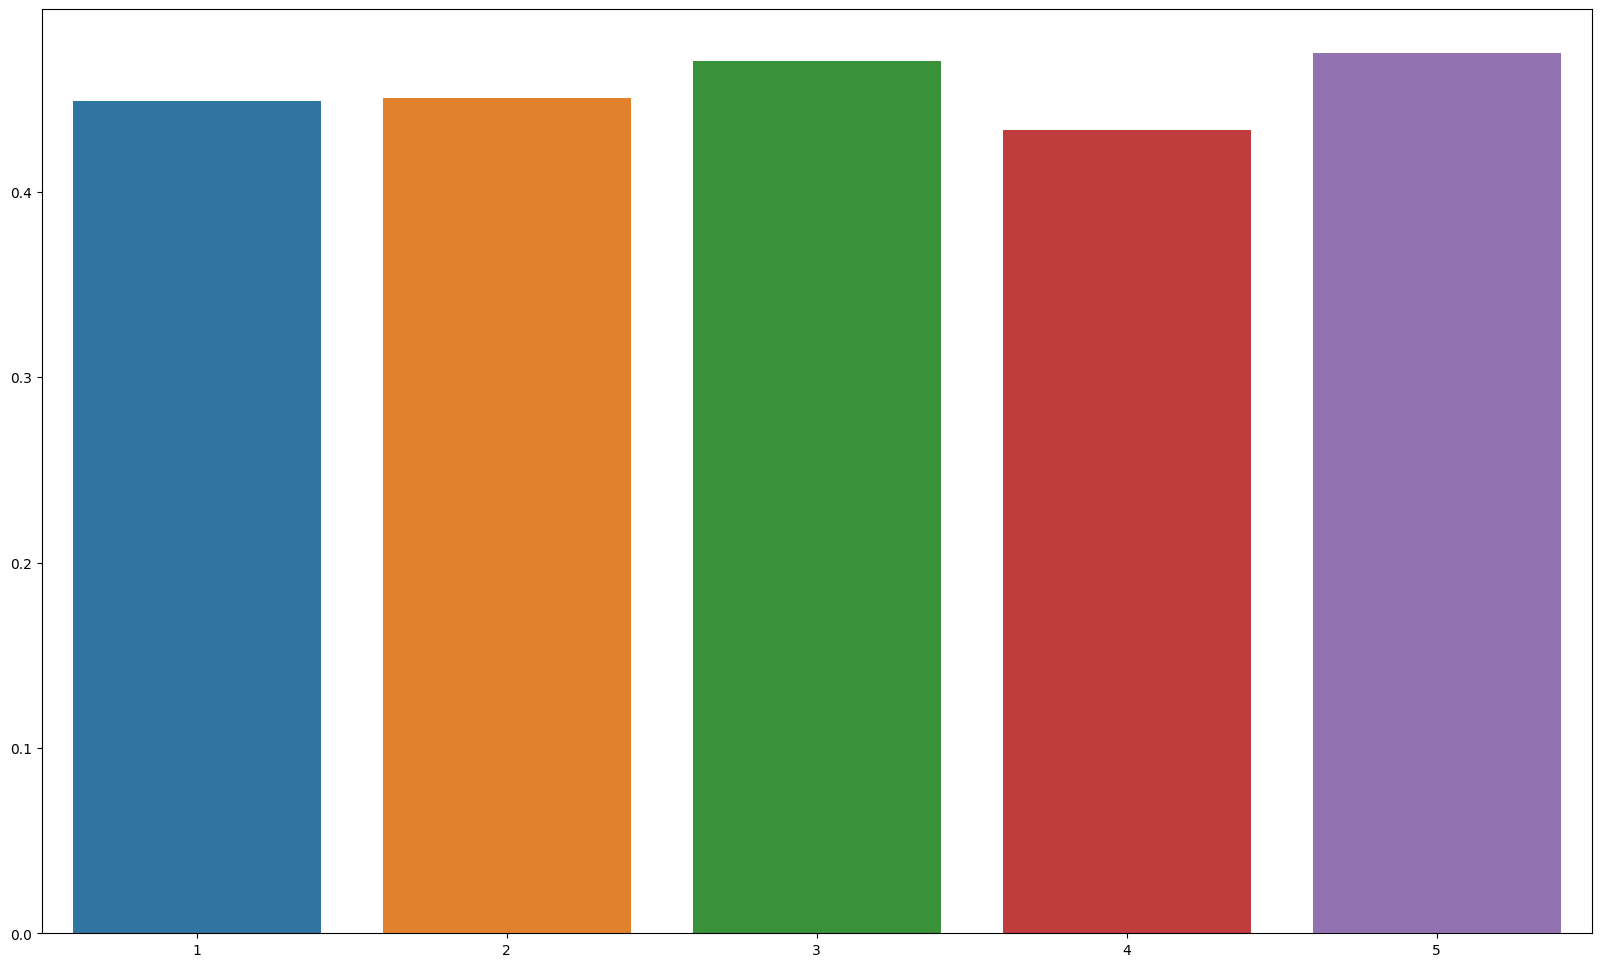

In [17]:
a, b = zip(*enumerate(scores))
a , b = np.array(a)+1 , np.array(b)
plt.figure(figsize = (20 ,12))
sns.barplot(x = a , y = b )

In [18]:
model.fit(X , y)
pred =convert(model.predict(test_m) , scaling_fact = 1 ,thresholds= [ 28.569125484672444
                                                                                                       ,36.17314930012063
                                                                                                       , 80.42835371337772])
pred

array([0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1.], dtype=float32)

In [19]:


sub = pd.DataFrame({"id":id_test , "sii":pred})
sub.to_csv("submission.csv" , index=False)